<a href="https://colab.research.google.com/github/BuczynskiRafal/pipe_calculations/blob/main/Catchments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install extensions

In [2]:
!pip install pyswmm
!pip install swmmio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import 

In [3]:
import os
import swmmio
import tempfile
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from swmmio.utils.dataframes import dataframe_from_inp
from swmmio.utils.text import get_inp_sections_details
from swmmio.utils.modify_model import replace_inp_section
from swmmio.version_control.utils import write_inp_section
from pyswmm import Simulation, Nodes, Links, Subcatchments, Output

# Prepare model for managing

In [8]:
#initialize a baseline model object
baseline = swmmio.Model('example.inp')
#create copy the base model 
newfilepath = os.path.join(baseline.inp.name + "_" + 'copy' + '.inp')
# save new file
baseline.inp.save(newfilepath)

# Explore model data

In [70]:
model = swmmio.Model('example_copy.inp')
df_subcatchments = dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')

In [71]:
df_subcatchments[:2]

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,1.01,0


In [11]:
df_subcatchments.loc["S1", "PercImperv"] = 15
model.inp.subcatchments = df_subcatchments

In [12]:
df_subcatchments[:2]

,Raingage,Outlet,...,PercSlope,CurbLength
Name,,,,,
S1,1,J1,...,10,0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [13]:
''' PySWMM doesn't allow to set percent imprevious parameter.
It's important to check impact this feature on runoff.
This is the reason to overide imprevious value in dataftame 
and overwrite model with new data.
'''
def overwrite_percent_imprevious(value: float, subcatchment_id: str, file_path: str = 'example_copy.inp') -> None:
    model = swmmio.Model(file_path)

    #create a dataframe of the model's subcatchments
    subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')

    # subcatchments = model.subcatchments.dataframe
    subcatchments.loc[subcatchment_id, "PercImperv"] = value

    #overwrite file with new data
    swmmio.utils.modify_model.replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)

# overwrite_percent_imprevious(value=50, subcatchment_id='S1', file_path='example_copy.inp')


In [14]:
model = swmmio.Model('example_copy.inp')
sub = model.subcatchments.dataframe
sub.head()

,Raingage,Outlet,...,RouteTo,coords
Name,,,,,
S1,1,J1,...,OUTLET,"[(777172.413, 592589.245), (777181.812, 592589.633), (777181.932, 592580.323), (777172.652, 592580.174), (777172.413, 592589.364), (777172.413, 592589.245)]"


In [72]:
def calculate(subcatchment_id=None, conduit_id=None, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        conduit = Links(sim)[conduit_id]
        for _ in sim: pass
        return catchment.statistics, conduit.conduit_statistics
        

def simulate_catchment_features(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, area = [], [], []
    for a in range(1, 16, 1):
        for s in iterator:
            for i in iterator:
                slope.append(s)
                percent_impervious.append(i)
                area.append(a)
                model = swmmio.Model(file_path)
                subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
                subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
                subcatchments.loc[subcatchment_id, "PercImperv"] = i
                subcatchments.loc[subcatchment_id, "Area"] = a
                replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                catchment_stats = calculate(subcatchment_id=subcatchment_id,  conduit_id=conduit_id, file_path=model.inp.path)
                conduit_stats = conduit
                for key in catchment_data:
                    catchment_data[key].append(catchment_stats[key])
                counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = area
    return pd.DataFrame(data=catchment_data)


In [17]:
analyse = simulate_catchment_features(subcatchment_id='S1', min=1, max=100, step=10, file_path='example_copy.inp')

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [18]:
analyse.head()

,runoff,peak_runoff_rate,...,slope,percent_impervious
0,4147.421663,0.708872,...,1,1
1,4309.578675,0.820048,...,1,11
2,4453.766020,0.926754,...,1,21
3,4580.965259,1.027848,...,1,31
4,4690.803627,1.121749,...,1,41


# Simulate percent imprevious feature 

## Prepare method for simulation

In [19]:
def simulate_percent_imprevious(subcatchment_id=None, min=0.1, max=100, step=0.1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    percent_impervious = []
    counter = min
    while counter < max:
        model = swmmio.Model(file_path)
        subcatchments = swmmio.utils.dataframes.dataframe_from_inp(model.inp.path, '[SUBCATCHMENTS]')
        subcatchments.loc[subcatchment_id, "PercImperv"] = counter
        percent_impervious += counter,
        replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
        catchment_stats = calculate(subcatchment_id=subcatchment_id, min=min, max=max, step=step, file_path=model.inp.path)
        for key in catchment_data:
            catchment_data[key].append(catchment_stats[key])
        counter += step
    catchment_data["percent_impervious"] = percent_impervious
    return pd.DataFrame(data=catchment_data)


## Get imprevious data

In [20]:
df_percent_imprevious =  simulate_percent_imprevious(subcatchment_id='S1', min=1, max=100, step=1, file_path='example_copy.inp')

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [21]:
df_percent_imprevious.head()

,runoff,peak_runoff_rate,infiltration,evaporation,percent_impervious
0,4850.300587,1.368797,165.589703,0.0,1
1,4852.594601,1.369408,163.273817,0.0,2
2,4854.908903,1.370003,160.966017,0.0,3
3,4857.258760,1.370582,158.669494,0.0,4
4,4859.628829,1.371142,156.385465,0.0,5


In [22]:
df_percent_imprevious.shape

(99, 5)

## Subcatchments data output


### Dependence of runoff on subcatchment imprevious.


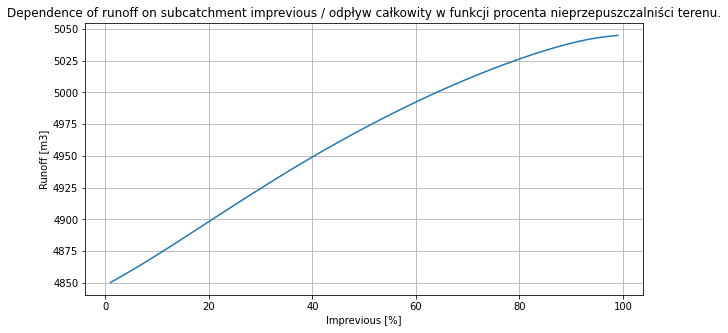

In [23]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['runoff'])
plt.title('Dependence of runoff on subcatchment imprevious / odpływ całkowity w funkcji procenta nieprzepuszczalniści terenu.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment imprevious.


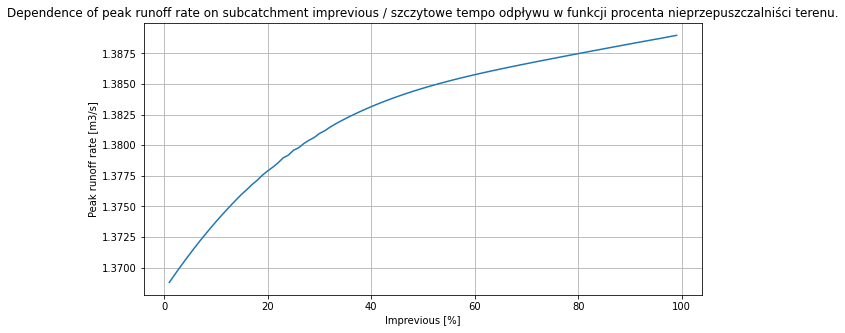

In [24]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment imprevious / szczytowe tempo odpływu w funkcji procenta nieprzepuszczalniści terenu.')
plt.xlabel('Imprevious [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment imprevious


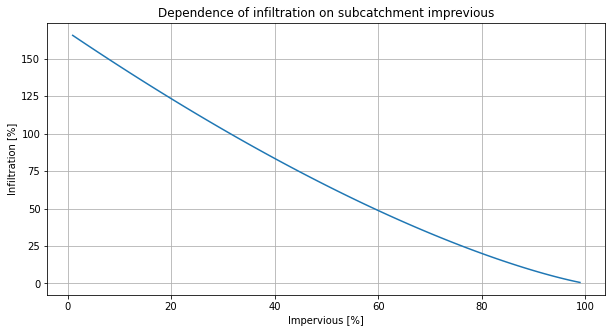

In [25]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_percent_imprevious['percent_impervious'], df_percent_imprevious['infiltration'])
plt.title('Dependence of infiltration on subcatchment imprevious')
plt.xlabel('Impervious [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

# Simulate percent slope feature

## Prepare methoed for analyse slope

In [40]:
def simulate_catchments_slope(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    slope = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.slope = counter/100
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            conduit_stats = conduit.conduit_statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            for key in conduit_data:
                conduit_data[key].append(conduit_stats[key])
            slope.append(counter)
        counter += step
    catchment_data["slope"] = slope
    return pd.DataFrame(data={**catchment_data, **conduit_data})

## Get slope data

In [41]:
df_slope = simulate_catchments_slope("S1", "C3")

In [42]:
df_slope.head()

,runoff,peak_runoff_rate,...,time_full_upstream,time_normal_flow
0,4911.217316,1.379508,...,0.0,1.897309
1,4924.916177,1.382164,...,0.0,2.408088
2,4931.952280,1.382755,...,0.0,2.666416
3,4936.695570,1.382933,...,0.0,2.828637
4,4940.197788,1.383007,...,0.0,2.919575


## Subcatchment data output

### Dependence of runoff on subcatchment slope.

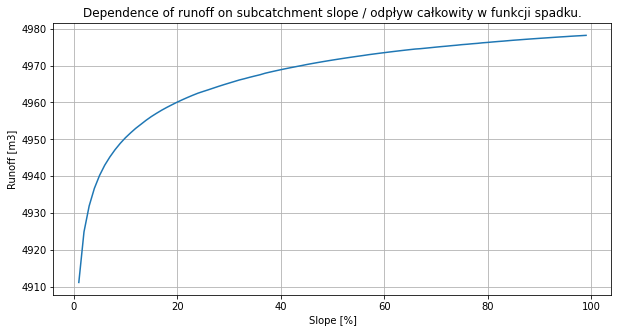

In [43]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['runoff'])
plt.title('Dependence of runoff on subcatchment slope / odpływ całkowity w funkcji spadku.')
plt.xlabel('Slope [%]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment slope

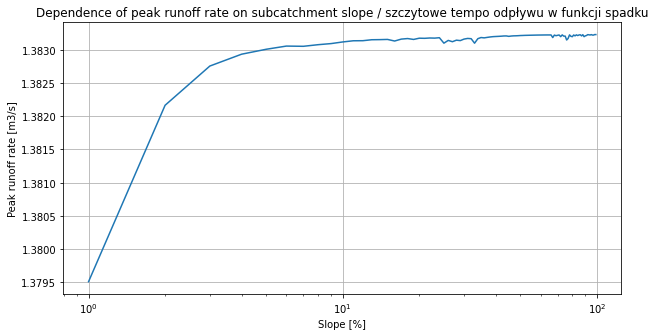

In [44]:
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment slope / szczytowe tempo odpływu w funkcji spadku')
plt.xlabel('Slope [%]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment slope

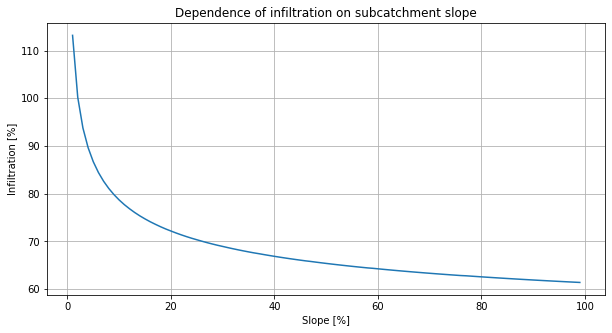

In [45]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['infiltration'])
plt.title('Dependence of infiltration on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

### Dependence of maximal flow on subcatchment slope.

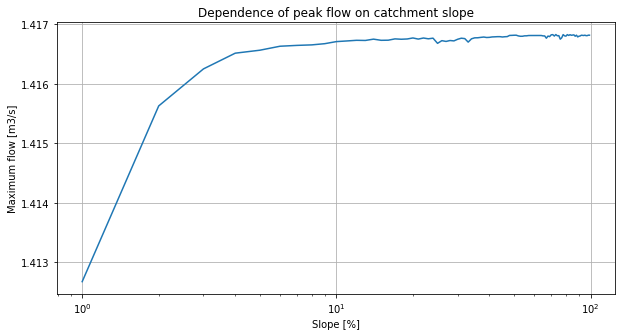

In [46]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_flow'])
plt.title('Dependence of peak flow on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

### Dependence of maximal velocity on subcatchment slope


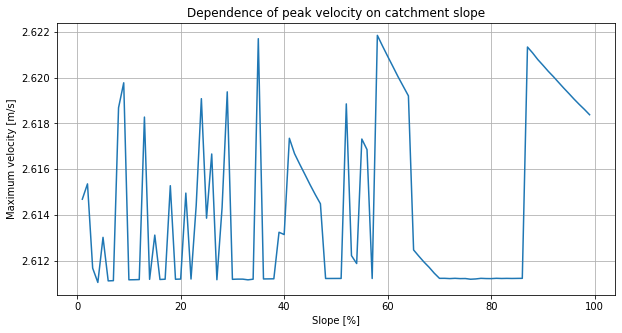

In [47]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_velocity'])
plt.title('Dependence of peak velocity on catchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

### Dependence of maximal pipe filling on subcatchment slope.

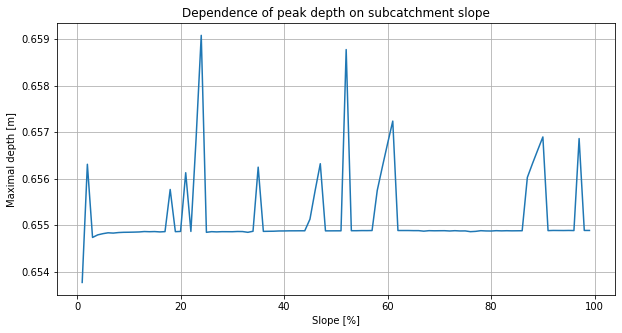

In [48]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_slope['slope'], df_slope['peak_depth'])
plt.title('Dependence of peak depth on subcatchment slope')
plt.xlabel('Slope [%]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

# Simulate area feature

## Prepare method for simulation

In [51]:
def simulate_catchments_area(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    area = []
    counter = min
    while counter < max:
        with Simulation(file_path) as sim:
            catchment = Subcatchments(sim)[subcatchment_id]
            conduit = Links(sim)[conduit_id]
            catchment.area = counter
            for _ in sim:
                pass
            catchment_stats = catchment.statistics
            conduit_stats = conduit.conduit_statistics
            for key in catchment_data:
                catchment_data[key].append(catchment_stats[key])
            for key in conduit_data:
                conduit_data[key].append(conduit_stats[key])
            area.append(counter)
        counter += step
    catchment_data["area"] = area
    return pd.DataFrame(data={**catchment_data, **conduit_data})

## Get area data

In [52]:
df_area = simulate_catchments_area("S1", "C3")

In [53]:
df_area.head()

,runoff,peak_runoff_rate,...,time_full_upstream,time_normal_flow
0,996.596274,0.276626,...,0.0,4.242144
1,1989.570566,0.553289,...,0.0,3.551445
2,2978.552360,0.829890,...,0.0,2.928762
3,3965.384309,1.106532,...,0.0,2.489477
4,4950.427329,1.383118,...,0.0,2.533971


## Subcatchments data output

### Dependence of runoff on subcatchment area.

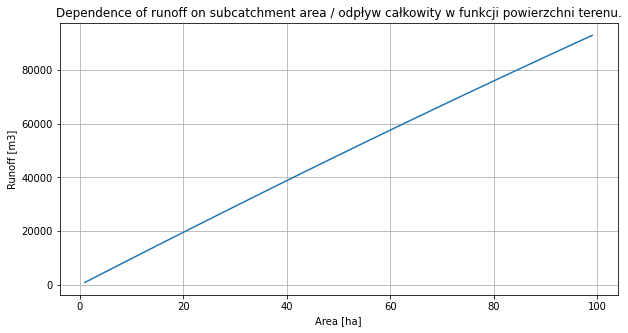

In [63]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['runoff'])
plt.title('Dependence of runoff on subcatchment area / odpływ całkowity w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Runoff [m3]')
plt.grid(True)
plt.show()

### Dependence of peak runoff rate on subcatchment area.

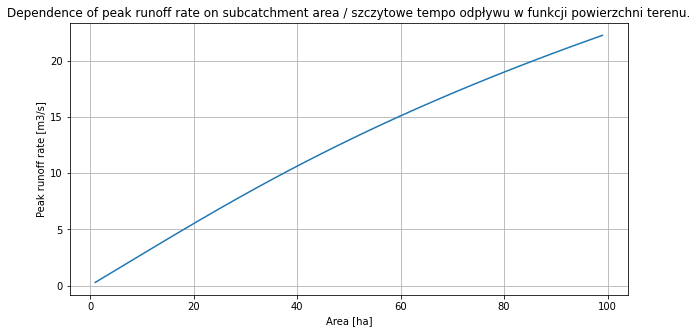

In [64]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_runoff_rate'])
plt.title('Dependence of peak runoff rate on subcatchment area / szczytowe tempo odpływu w funkcji powierzchni terenu.')
plt.xlabel('Area [ha]')
plt.ylabel('Peak runoff rate [m3/s]')
plt.grid(True)
plt.show()

### Dependence of infiltration on subcatchment area.

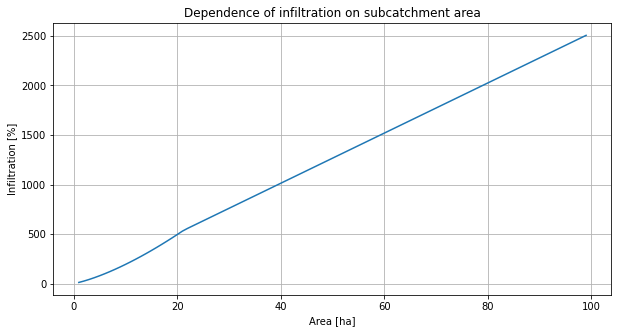

In [65]:
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['infiltration'])
plt.title('Dependence of infiltration on subcatchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Infiltration [%]')
plt.grid(True)
plt.show()

### Dependence of maximal flow on subcatchment area.

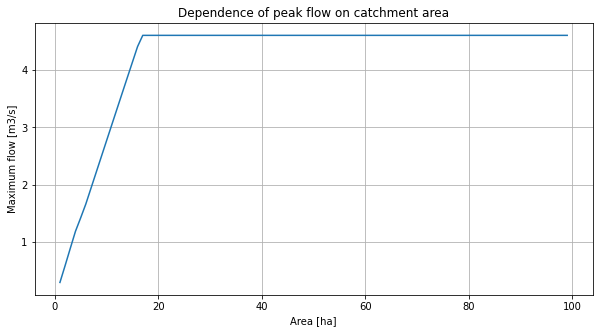

In [66]:
# maksymaly przepływ [m3/s] w funkcji spadku terenu zlewni.
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_flow'])
plt.title('Dependence of peak flow on catchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Maximum flow [m3/s]')
plt.grid(True)
plt.show()

### Dependence of maximal velocity on subcatchment area

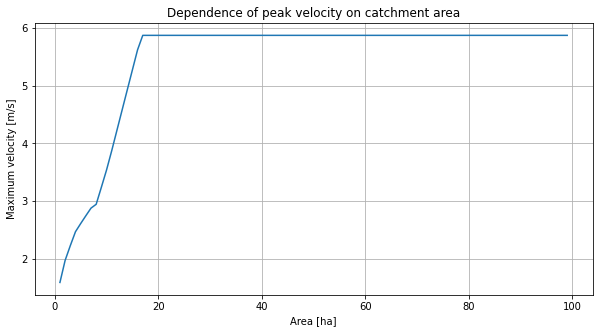

In [67]:
# peak_velocity - maksymalna prędkość przepływu [m/s]
# plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_velocity'])
plt.title('Dependence of peak velocity on catchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Maximum velocity [m/s]')
plt.grid(True)
plt.show()

### Dependence of maximal pipe filling on subcatchment area.

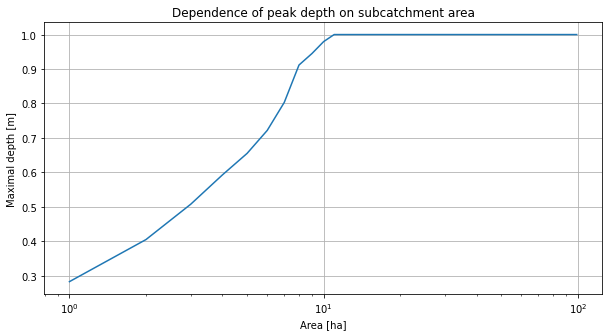

In [68]:
# maksymalna wysokość napełnienia kanału  w sunkcji spadku terenu zlewni [m]
plt.xscale("log")
plt.rcParams["figure.figsize"] = (10,5)
plt.plot(df_area['area'], df_area['peak_depth'])
plt.title('Dependence of peak depth on subcatchment area')
plt.xlabel('Area [ha]')
plt.ylabel('Maximal depth [m]')
plt.grid(True)
plt.show()

In [18]:
def simulate_catchment(subcatchment_id=None, min_slope=0.1, max_slope=100, step=0.1, file_path='example.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    iterator = [min_slope]
    counter = min_slope
    while counter < max_slope:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, areas, runoff_total_loading = [], [], [], []
    conc_ponded, buildup, evaporation_loss = [], [], []
    for a in range(1, 30, 1):
        for s in iterator:
            for i in iterator:
                with Simulation(file_path) as sim:
                    catchment = Subcatchments(sim)[subcatchment_id]
                    catchment.slope = s
                    catchment.percent_impervious = i
                    catchment.area = a
                    runoff_total_loading.append(catchment.runoff_total_loading)
                    conc_ponded.append(catchment.conc_ponded)
                    buildup.append(catchment.buildup)
                    evaporation_loss.append(catchment.evaporation_loss)
                    slope.append(s)
                    percent_impervious.append(catchment.percent_impervious) 
                    print(catchment.percent_impervious)
                    areas.append(a)
                    for _ in sim:
                        pass
                    catchment_stats = catchment.statistics
                    for key in catchment_data:
                        catchment_data[key].append(catchment_stats[key])
        print(f"loop: {a}")
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = areas
    return pd.DataFrame(data=catchment_data)

# Simulate all feature

## Prepare method for simulation

In [97]:
def calculate(subcatchment_id=None, conduit_id=None, file_path='example_copy.inp'):
    with Simulation(file_path) as sim:
        catchment = Subcatchments(sim)[subcatchment_id]
        conduit = Links(sim)[conduit_id]
        for _ in sim: pass
        return catchment.statistics, conduit.conduit_statistics
        

def simulate_catchment_features(subcatchment_id=None, conduit_id=None, min=1, max=100, step=1, file_path='example_copy.inp'):
    catchment_data = {"runoff": [], "peak_runoff_rate": [], "infiltration": [], "evaporation": []}
    conduit_data = {'flow_turn_sign': [], 'flow_turns': [], 'peak_depth': [], 'peak_flow': [], 'peak_flow_date': [], 'peak_velocity': [], 'time_capacity_limited': [], 'time_courant_crit': [], 'time_full_downstream': [], 'time_full_flow': [], 'time_full_upstream': [], 'time_normal_flow': []}
    iterator = [min]
    counter = min
    while counter < max:
        counter += step
        iterator.append(counter)
    slope, percent_impervious, area = [], [], []
    for a in range(1, 5, 1):
        for s in iterator:
            for i in iterator:
                slope.append(s)
                percent_impervious.append(i)
                area.append(a)
                model = swmmio.Model(file_path)
                subcatchments = swmmio.utils.dataframes.dataframe_from_inp(file_path, '[SUBCATCHMENTS]')
                # subcatchments.loc[subcatchment_id, "PercSlope"] = s/100
                subcatchments.loc[subcatchment_id, "PercImperv"] = i
                # subcatchments.loc[subcatchment_id, "Area"] = a
                replace_inp_section(model.inp.path, '[SUBCATCHMENTS]', subcatchments)
                
                with Simulation(model.inp.path) as sim:
                    catchment = Subcatchments(sim)[subcatchment_id]
                    conduit = Links(sim)[conduit_id]
                    catchment.slope = s/100
                    catchment.area = a
                    for _ in sim: pass
                    catchment_stats = catchment.statistics
                    conduit_stats = conduit.conduit_statistics
                
                # catchment_stats, conduit_stats = calculate(subcatchment_id=subcatchment_id,  conduit_id=conduit_id, file_path=model.inp.path)
                for key in catchment_data:
                    catchment_data[key].append(catchment_stats[key])
                for key in conduit_data:
                    conduit_data[key].append(conduit_stats[key])
                counter += step
    catchment_data["slope"] = slope
    catchment_data["percent_impervious"] = percent_impervious
    catchment_data["area"] = area
    return pd.DataFrame(data={**catchment_data, **conduit_data})


## Get features data

In [98]:
analyse = simulate_catchment_features("S1", "C3", step=100)

example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to initialize
local variable 'swmm_version' referenced before assignment
example_copy.rpt failed to ini

In [99]:
analyse.head()

,runoff,peak_runoff_rate,...,time_full_upstream,time_normal_flow
0,987.466919,0.276256,...,0.0,3.886615
1,1007.257221,0.277803,...,0.0,4.649386
2,994.073353,0.276281,...,0.0,4.707558
3,1000.540101,0.277806,...,0.0,4.082853
4,1962.245805,0.552364,...,0.0,3.149747


In [95]:
analyse.shape

(16, 19)

## Subcatchments data output

### Show feature correlations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


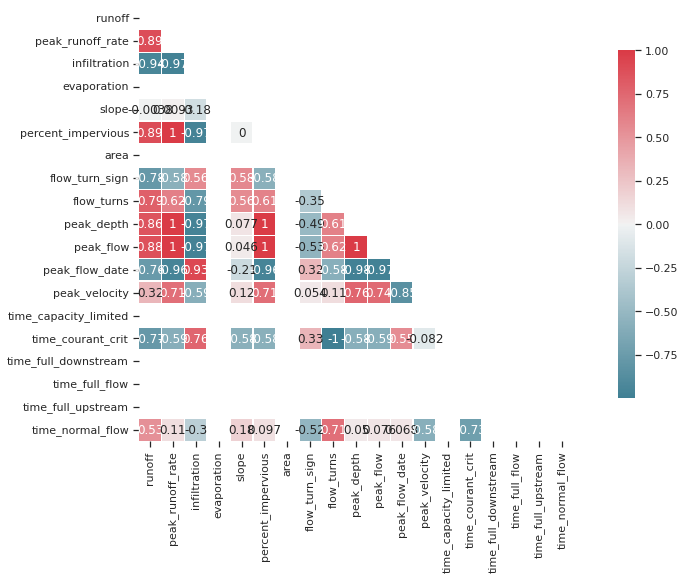

In [91]:
df_corr = analyse.copy()
corr = df_corr.corr()

sns.set(style="ticks")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(16, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.8})